# Analysing gene expression data with XGBoost

XGBoost (Extreme Gradient Boosting) is another choice of analysing biological data. While Random Forest builds trees independently and averages them, XGBoost builds trees sequentially, with each new tree trying to correct the errors of the previous ones. XGBoost can be great for handling biological data like gene expression:

* Built-in regularization: Gene expression data suffers from "The Curse of Dimensionality" ($p \gg n$), where you have 20,000 genes but only 100 patients. XGBoost uses L1 (Lasso) and L2 (Ridge) regularization to automatically "silence" unimportant genes, preventing the model from just memorizing the noise;

* Sparsity Awareness: If your data has missing values (common in Single-Cell RNA-seq or older Microarrays), XGBoost can natively learn the best direction to handle them without you having to "impute" or guess the missing numbers.

## Overview
Build a XGBoost classifier that diagnoses lung cancer using gene expression data, then evaluate and visualise results.

## Step 1. Load gene expression data from public database

We can load gene expression data using GeoParser from existing soft files. 

To download the data, one can go to the [W1 notebook](../W1/w1_1_random_forest_classifier.ipynb)

In [ ]:
import GEOparse
gse = GEOparse.get_GEO(filepath="../W1/GSE19804_family.soft.gz")

03-Jan-2026 14:43:14 INFO GEOparse - Parsing ../W1/GSE19804_family.soft.gz: 
03-Jan-2026 14:43:14 DEBUG GEOparse - DATABASE: GeoMiame
03-Jan-2026 14:43:14 DEBUG GEOparse - SERIES: GSE19804
03-Jan-2026 14:43:14 DEBUG GEOparse - PLATFORM: GPL570
/opt/anaconda3/envs/bioinfor-to-ai-env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
03-Jan-2026 14:43:15 DEBUG GEOparse - SAMPLE: GSM494556
03-Jan-2026 14:43:15 DEBUG GEOparse - SAMPLE: GSM494557
03-Jan-2026 14:43:15 DEBUG GEOparse - SAMPLE: GSM494558
03-Jan-2026 14:43:16 DEBUG GEOparse - SAMPLE: GSM494559
03-Jan-2026 14:43:16 DEBUG GEOparse - SAMPLE: GSM494560
03-Jan-2026 14:43:16 DEBUG GEOparse - SAMPLE: GSM494561
03-Jan-2026 14:43:16 DEBUG GEOparse - SAMPLE: GSM494562
03-Jan-2026 14:43:16 DEBUG GEOparse - SAMPLE: GSM494563
03-Jan-2026 14:43:16 DEBUG GEOparse - SAMPLE: GSM49456

In [ ]:
## Step 2. Extract gene expression (X) and labels (y)

In [ ]:
# --- Extract Labels ---
# Get metadata to find our groups (e.g., 'treatment' vs 'control')
metadata = gse.phenotype_data

# Identify the labels for classification in metadata
labels = metadata['characteristics_ch1.0.tissue']

labels.value_counts()  # Check the distribution of labels

characteristics_ch1.0.tissue
lung cancer               60
paired normal adjacent    60
Name: count, dtype: int64

In [ ]:
# --- Extract gene expression matrix (genes as rows, samples as columns) ---
data = gse.pivot_samples('VALUE')

# log-transform the gene expression data
import numpy as np
data = np.log2(data + 1)

data.shape # Check the shape of the expression matrix

(54675, 120)

## Step 3. Build XGB classifier

Make sure the you install the `xgboost` package before running the below code block:

In [ ]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# --- Preprocessing ---
# This will turn 'lung cancer' into 1 and 'normal' into 0 (alphabetical order), SGB is picky about numeric labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

# Transpose so samples are rows and genes are columns
X = data.T 


# Prepare Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 2. Initialize the Classifier
# 'binary:logistic' is for 2-class problems; use 'multi:softprob' for more classes
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,          # Shorter trees prevent overfitting in biology
    learning_rate=0.1,    # The "step size" for each tree
    objective='binary:logistic',
    random_state=42
)

# 3. Train the Model
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Step 4. Evaluate the results

Below is a checklist of the model performance:

1. Confusion Matrix: To show where the model fails.   
2. Learning Curve: To prove you didn't overfit.
3. Top 10 Genes Table: To compare with existing literature.
4. SHAP Plot: Up-regulation and down-regulation.

### 4.1. Confusion Matrix
Bio-projects need to demonstrate precision/recall and confusion matrix is a great way for visualization. It shows if the model misclassifies healthy versus cancer or vice versa.

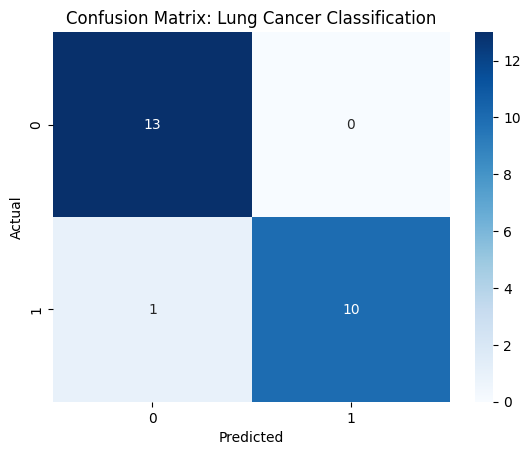

In [ ]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Lung Cancer Classification')
plt.show()

### 4.2. Learning Curve

XGBoost allows you to monitor how the model "learns" over time. By passing a validation set to the fit method, you can plot the error rate for every single tree added to the forest.   

This is the best way to detect overfitting: If the "test" line starts going up while the "train" line keeps going down, your model is over-fitting to the specific genes in your training set and won't work on new patients.

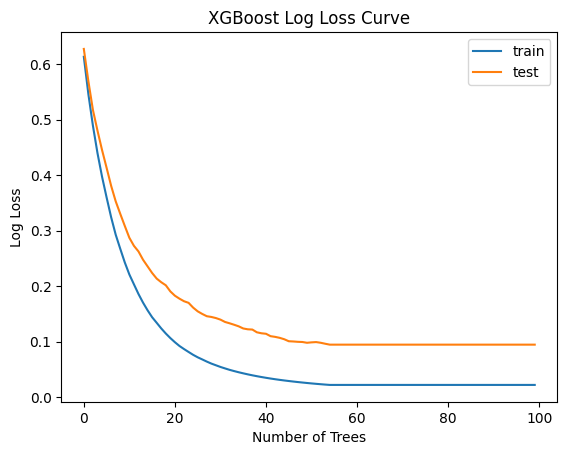

In [ ]:
# Train with an evaluation set
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)], 
          verbose=False)

# Retrieve performance metrics
results = model.evals_result()

# Plotting
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.title('XGBoost Log Loss Curve')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

### 4.3. Top 10 Genes Table

XGBoost is famous for its ability to rank features. You can plot the genes that the model relied on most.

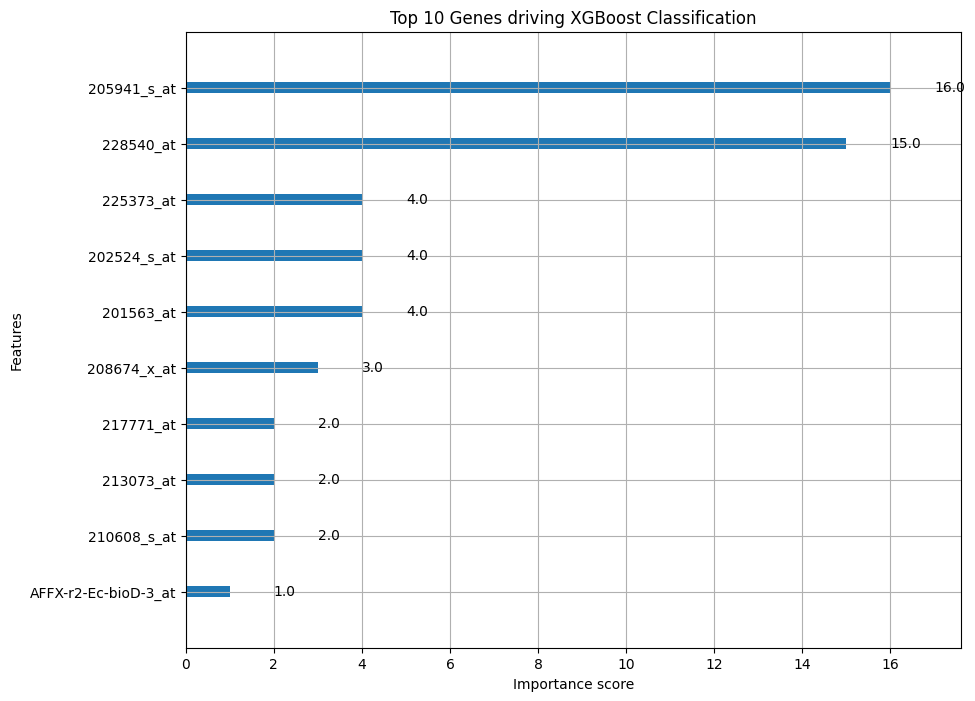

In [ ]:
from xgboost import plot_importance

# Plot the top 20 genes
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model, max_num_features=10, ax=ax)
plt.title("Top 10 Genes driving XGBoost Classification")
plt.show()

Apart from the default, XGBoost’s built-in importance actually has three different "flavors" you can toggle. If you only use the default, you might get a biased view of your genes.   

* Weight (Frequency): How many times a gene is used to split data across all trees.
* Gain: The average improvement in accuracy brought by a gene. (Usually the most biologically relevant).
* Cover: The average number of samples affected by splits using that gene.

In [ ]:
importance_gain = model.get_booster().get_score(importance_type='gain') # Change the importance type to 'gain'
importance_cover = model.get_booster().get_score(importance_type='cover')
importance_weight = model.get_booster().get_score(importance_type='weight')
# Visualize the importance scores by flavor
importance_df = pd.DataFrame({
    'Gene': list(importance_gain.keys()),
    'Gain': list(importance_gain.values()),
    'Cover': [importance_cover.get(gene, 0) for gene in importance_gain.keys()],
    'Weight': [importance_weight.get(gene, 0) for gene in importance_gain.keys()]
})
importance_df.sort_values(by='Weight', ascending=False).head()

,Gene,Gain,Cover,Weight
24,205941_s_at,16.079805,10.950397,16.0
39,228540_at,21.124147,13.913100,15.0
19,201563_at,1.063077,2.704631,4.0
20,202524_s_at,3.862190,5.914402,4.0
38,225373_at,2.534575,4.484333,4.0


### 4.4. SHAP (The "Gold Standard" for Interpretation)
While plot_importance tells you that a gene is important, it doesn't tell you how it affects the prediction. SHAP (SHapley Additive exPlanations) is a library that works perfectly with XGBoost to show: "If Gene X expression goes up, does the probability of cancer go up or down?"

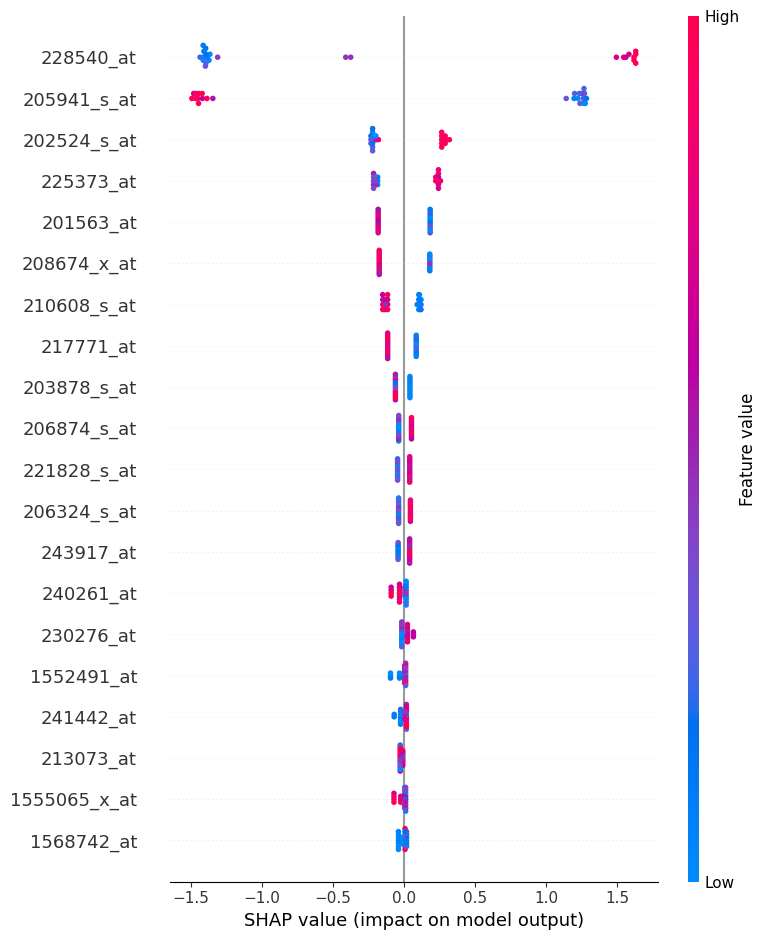

In [ ]:
import shap
import numpy as np

# Note Use XGBoost's native 'predict' method with pred_contribs=True
# This calculates the SHAP values internally without the parsing error of string/float
booster = model.get_booster()
shap_values = booster.predict(xgb.DMatrix(X_test), pred_contribs=True)

# 2. Extract the SHAP values
# Note: pred_contribs returns an extra column at the end (the 'expected value')
# We separate the contributions from the base value
expected_value = shap_values[:, -1][0]
shap_values_matrix = shap_values[:, :-1]

# 3. Create the plot
# We pass the matrix and the original feature names for the display
shap.summary_plot(shap_values_matrix, X_test, feature_names=X_test.columns)

In this study, Gene 228540_at at the top has red dots on the far right, it tells us "High expression of Gene 228540 is a strong positive predictor for lung cancer"; it also has blue dots on the far left, it tells us "Low expression of Gene 228540 is a strong negative predictor for lung cancer".